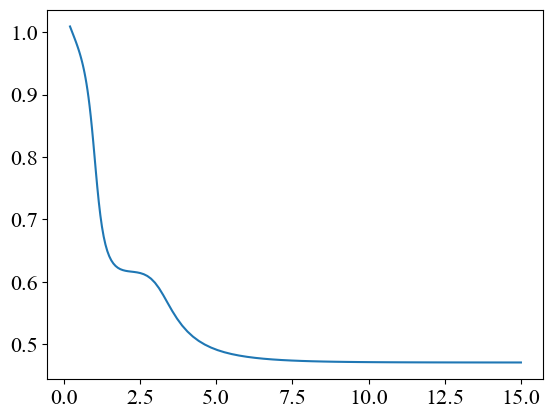

In [11]:
import numpy as np
from disba import PhaseDispersion, depthplot
from utils import gen_model1
import matplotlib.pyplot as plt

# Periods must be sorted starting with low periods
start, end = 0.2, 15
t = np.logspace(np.log10(1/end), np.log10(1/start), 100)


# Velocity model
# thickness, Vp, Vs, density
# km, km/s, km/s, g/cm3
thick_true = np.array([0.07,0.07,0.08,1.0])
vs_true    = np.array([0.5,0.9,0.5, 1.1])
thick_true,vp_true,vs_true,rho_true = gen_model1(thick_true,vs_true,area=True)
velocity_model = np.array([
    thick_true.tolist(),
    vp_true.tolist(),
    vs_true.tolist(),
    rho_true.tolist(),
])

velocity_model = velocity_model.T

# Compute the 3 first Rayleigh- and Love- wave modal dispersion curves
# Fundamental mode corresponds to mode 0
pd = PhaseDispersion(*velocity_model.T)
cpr = pd(t, mode=0, wave="rayleigh")
# cpl = [pd(t, mode=i, wave="love") for i in range(3)]

period = cpr.period
data = cpr.velocity
# pd returns a namedtuple (period, velocity, mode, wave, type)

plt.plot(1./period, data, label="Rayleigh 0")

In [2]:
velocity_model

array([[0.07 , 1.225, 0.5  , 2.   ],
       [0.07 , 2.205, 0.9  , 2.   ],
       [0.08 , 1.225, 0.5  , 2.   ],
       [0.2  , 2.695, 1.1  , 2.   ]])

In [12]:
from evodcinv import EarthModel, Layer, Curve

# Initialize model
model = EarthModel()

#                   d [km]     vs [km/s]
#                min    max    min  max
model.add(Layer([0.02, 0.1], [0.4, 0.7]))  # Layer 1
model.add(Layer([0.02, 0.1], [0.4, 1.3]))  # Layer 1
model.add(Layer([0.02, 0.1], [0.4, 1.3]))  # Layer 1
model.add(Layer([1.0, 1.0], [0.4, 1.3]))  # Layer 1

# Configure model
model.configure(
    optimizer      = "cmaes",       # Evolutionary algorithm,'cmaes','cpso','de','na','pso','vdcma'
    misfit          = "rmse",        # Misfit function type, 'rmse','norm1','norm2'
    optimizer_args = {
                "popsize": 10,      # Population size
                "maxiter": 500,    # Number of iterations
                "workers": -1,      # Number of cores
                "seed"   : 10,
            },
)


curves = [Curve(period, data, 0, "rayleigh", "phase", weight=1.0, uncertainties=None)]

# Run inversion
res = model.invert(curves)
print(res)

pd = PhaseDispersion(*res.model.T)
cpr = pd(period, mode=0, wave="rayleigh")
# cpl = [pd(period, mode=i, wave="love") for i in range(3)]


Run 1   |███████▉            |  39% [0:00:10 / 0:00:24] - Misfit: 0.0001/Users/zhangzhiyu/miniconda3/envs/dasQt/lib/python3.12/site-packages/numpy/lib/function_base.py:4658: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t >= 0.5,
Run 1   |████████            |  39% [0:00:11 / 0:00:24] - Misfit: 0.0001/Users/zhangzhiyu/miniconda3/envs/dasQt/lib/python3.12/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
Run 1   |█████████████████   |  85% [0:00:23 / 0:00:05] - Misfit: 0.0001


--------------------------------------------------------------------------------
Best model out of 20000 models (1 run)

Velocity model                                    Model parameters
----------------------------------------          ------------------------------
         d        vp        vs       rho                   d        vs        nu
      [km]    [km/s]    [km/s]   [g/cm3]                [km]    [km/s]       [-]
----------------------------------------          ------------------------------
    0.0685    0.9425    0.5087    1.1991              0.0685    0.5087    0.2945
    0.0893    1.4912    0.8648    1.6294              0.0893    0.8648    0.2467
    0.0500    0.9615    0.4426    1.2169              0.0500    0.4426    0.3656
    1.0000    1.8665    1.1355    1.8424                   -    1.1355    0.2062
----------------------------------------          ------------------------------

Number of layers: 4
Number of parameters: 11
Best model misfit: 0.0001
-----------

DispersionError: failed to find root for fundamental mode

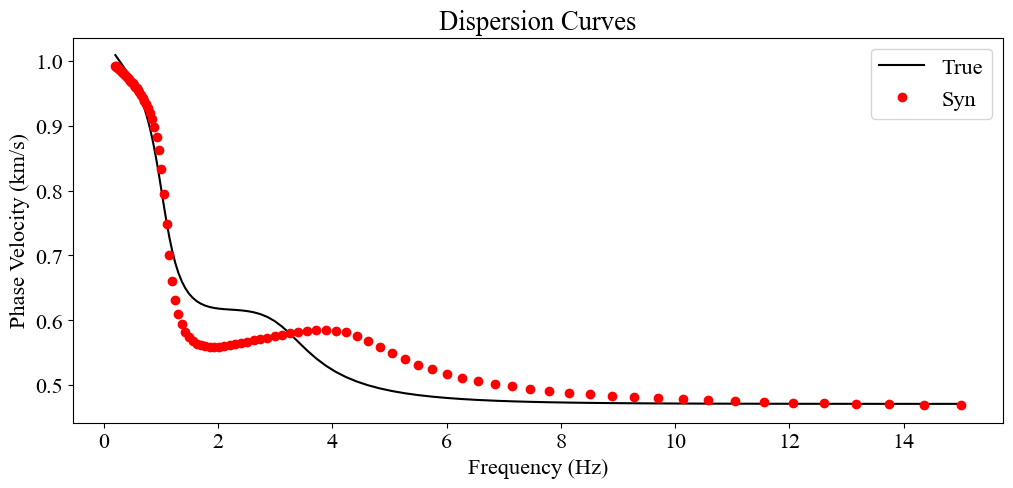

In [4]:
import matplotlib.pyplot as plt

# 设置字体为Times New Roman
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
plt.rcParams['font.size'] = 16

fig, ax = plt.subplots(1, 1, figsize=(12.0, 5))
ax.plot(1/period, data, 'k', label='True') 
ax.plot(1/cpr.period, cpr.velocity,'ro', label='Syn')
ax.legend()

ax.set_title('Dispersion Curves')
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Phase Velocity (km/s)')
ax.grid(False)

plt.show()

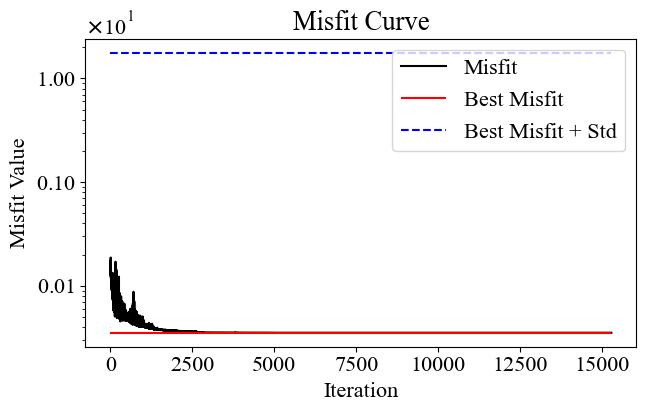

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

# 设置字体为Times New Roman
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
plt.rcParams['font.size'] = 16
fig, ax = plt.subplots(figsize=(16/9*4, 4))

ax.plot(res.misfits, 'k', label='Misfit')
ax.hlines(res.misfit, 0, len(res.misfits), 'r', label='Best Misfit')
ax.hlines(res.misfit*500.1, 0, len(res.misfits), 'b', linestyle='--', label='Best Misfit + Std')

# 设置y轴为log
ax.set_yscale('log')

ax.set_xlabel('Iteration')
ax.set_ylabel('Misfit Value')
ax.set_title('Misfit Curve')

ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

ax.legend()

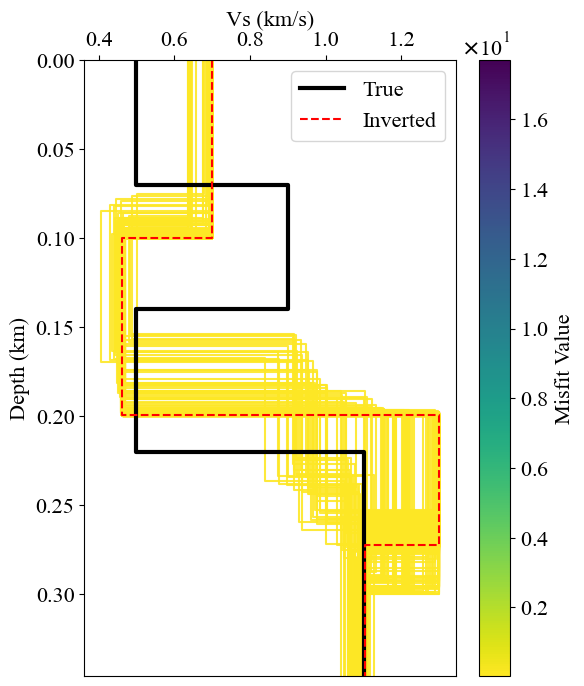

In [6]:

from matplotlib.ticker import ScalarFormatter


def getXinZin(thickness, parameter, ax=None):
    z = np.cumsum(thickness)    # Cumulative sum of thickness
    n = z.size 

    tmp = np.array(thickness)
    tmp[-1] = tmp[:-1].min()
    zmax = tmp.sum()

    # Build layered model
    xin = np.empty(2 * n)
    xin[1::2] = parameter
    xin[2::2] = parameter[1:]
    xin[0] = xin[1]

    zin = np.zeros_like(xin)
    zin[1:-1:2] = z[:-1]
    zin[2::2] = z[:-1]
    zin[-1] = max(z[-1], zmax)
    
    return xin, zin, zmax


fig, ax = plt.subplots(1, 1, figsize=(6.0, 8))

misfit_min = res.misfit
misfit_max = res.misfit*500.1

for i, (model, misfit) in enumerate(zip(res.models, res.misfits)):
    if i % 20 == 0 and i > 400:
        xin, zin, zmax = getXinZin(model[:, 0], model[:, 2])
        # ax.plot(xin, zin, color=plt.cm.viridis_r((misfit-misfit_min)/(misfit_max-misfit_min)), alpha=0.9)
        ax.plot(xin, zin, color=plt.cm.viridis_r((misfit - misfit_min) / (misfit_max - misfit_min)), alpha=0.9)

mappable = plt.cm.ScalarMappable(cmap='viridis_r', norm=plt.Normalize(vmin=misfit_min, vmax=misfit_max))
cbar = fig.colorbar(mappable, ax=ax, label='Misfit Value')

# 设置色阶条的标签为科学计数法
formatter = ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((-1,1))
cbar.formatter = formatter
cbar.update_ticks()


xin, zin, _ = getXinZin(thick_true, vs_true)
ax.plot(xin, zin, 'k', label='True', linewidth=3)


i = 2           #  1: Vp, 2: Vs, 3: density
thickness = res.model[:, 0]
parameter = res.model[:, i]
xin, zin, zmax = getXinZin(thickness, parameter)
ax.plot(xin, zin, 'r', linestyle='--', linewidth=1.5, label='Inverted')


zmax = zmax if zmax < thick_true.sum() else thick_true.sum()
ax.set_ylim(zin.min(),zmax)
ax.xaxis.set_ticks_position('top')  #将X坐标轴移到上面
ax.invert_yaxis()                   #反转Y坐标轴
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')  # 将x轴的标签也移动到顶部
ax.set_xlabel('Vs (km/s)')
ax.set_ylabel('Depth (km)')
# ax.set_title('Inverted Model')
ax.legend()


plt.show()

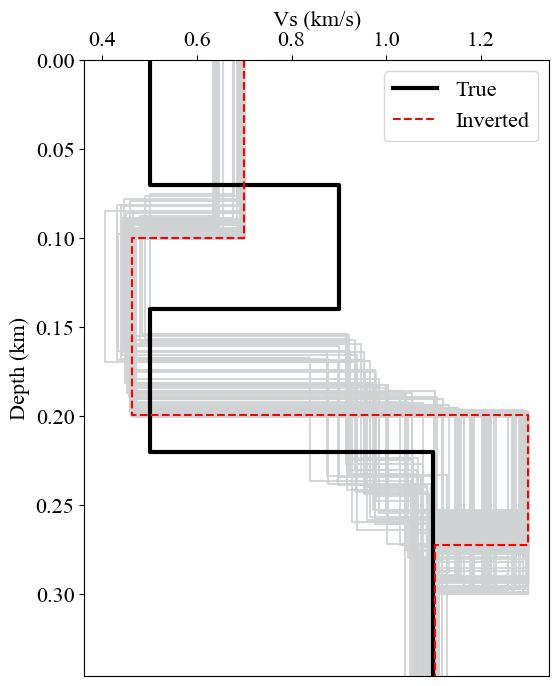

In [7]:

from matplotlib.ticker import ScalarFormatter


def getXinZin(thickness, parameter, ax=None):
    z = np.cumsum(thickness)    # Cumulative sum of thickness
    n = z.size 

    tmp = np.array(thickness)
    tmp[-1] = tmp[:-1].min()
    zmax = tmp.sum()

    # Build layered model
    xin = np.empty(2 * n)
    xin[1::2] = parameter
    xin[2::2] = parameter[1:]
    xin[0] = xin[1]

    zin = np.zeros_like(xin)
    zin[1:-1:2] = z[:-1]
    zin[2::2] = z[:-1]
    zin[-1] = max(z[-1], zmax)
    
    return xin, zin, zmax


fig, ax = plt.subplots(1, 1, figsize=(6.0, 8))

misfit_min = res.misfit
misfit_max = res.misfit*500.1

for i, (model, misfit) in enumerate(zip(res.models, res.misfits)):
    if i % 20 == 0 and i > 400:
        xin, zin, zmax = getXinZin(model[:, 0], model[:, 2])
        # ax.plot(xin, zin, color=plt.cm.viridis_r((misfit-misfit_min)/(misfit_max-misfit_min)), alpha=0.9)
        ax.plot(xin, zin, color='#D0D3D4', alpha=0.9)


xin, zin, _ = getXinZin(thick_true, vs_true)
ax.plot(xin, zin, 'k', label='True', linewidth=3)


i = 2           #  1: Vp, 2: Vs, 3: density
thickness = res.model[:, 0]
parameter = res.model[:, i]
xin, zin, zmax = getXinZin(thickness, parameter)
ax.plot(xin, zin, 'r', linestyle='--', linewidth=1.5, label='Inverted')


zmax = zmax if zmax < thick_true.sum() else thick_true.sum()
ax.set_ylim(zin.min(),zmax)
ax.xaxis.set_ticks_position('top')  #将X坐标轴移到上面
ax.invert_yaxis()                   #反转Y坐标轴
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')  # 将x轴的标签也移动到顶部
ax.set_xlabel('Vs (km/s)')
ax.set_ylabel('Depth (km)')
# ax.set_title('Inverted Model')
ax.legend()


plt.show()

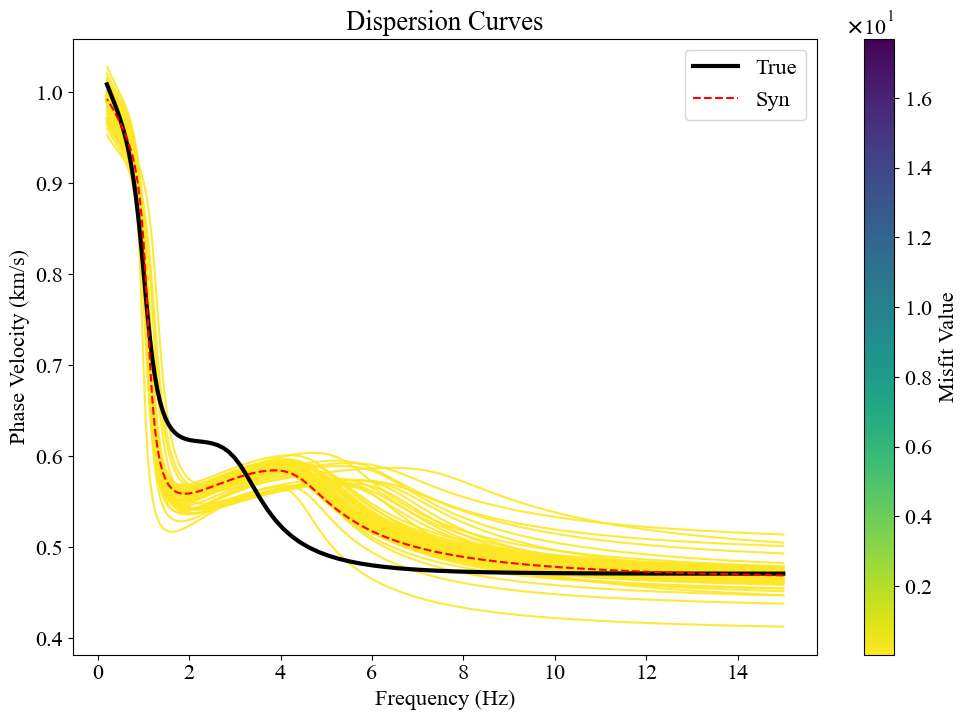

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

misfit_min = res.misfit
misfit_max = res.misfit*500.1

# 设置字体为Times New Roman
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
plt.rcParams['font.size'] = 16
fig, ax = plt.subplots(figsize=(12, 8))
for i, (model, misfit) in enumerate(zip(res.models, res.misfits)):
    pd = PhaseDispersion(*model.T)
    try:
        cpr = pd(period, mode=0, wave="rayleigh")
    except:
        continue
    if i % 20 == 0 and i > 400:
        ax.plot(1/cpr.period, cpr.velocity, color=plt.cm.viridis_r((misfit-misfit_min)/(misfit_max-misfit_min)), alpha=0.9)
        # ax.plot(1/cpr.period, cpr.velocity, color=plt.cm.viridis_r(misfit), alpha=0.5)

pd = PhaseDispersion(*res.model.T)
cpr = pd(period, mode=0, wave="rayleigh")
ax.plot(1/period, data, 'k', label='True', linewidth=3)
ax.plot(1/cpr.period, cpr.velocity, color='r', linestyle='--', label='Syn', linewidth=1.5)

# 添加颜色条并使用科学计数法
# mappable = plt.cm.ScalarMappable(cmap='viridis_r', norm=plt.Normalize(vmin=misfit_min, vmax=misfit_min*200))
mappable = plt.cm.ScalarMappable(cmap='viridis_r', norm=plt.Normalize(vmin=misfit_min, vmax=misfit_max))
cbar = fig.colorbar(mappable, ax=ax, label='Misfit Value')

# 设置色阶条的标签为科学计数法
formatter = ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((-1,1))
cbar.formatter = formatter
cbar.update_ticks()

ax.set_title('Dispersion Curves')
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Phase Velocity (km/s)')
ax.grid(False)

ax.legend()
plt.show()


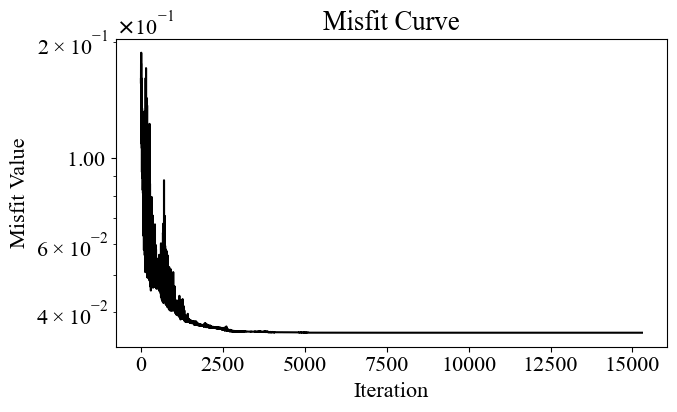

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

# 设置字体为Times New Roman
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
plt.rcParams['font.size'] = 16
fig, ax = plt.subplots(figsize=(16/9*4, 4))

ax.plot(res.misfits, 'k', label='Misfit')

# 设置y轴为log
ax.set_yscale('log')

ax.set_xlabel('Iteration')
ax.set_ylabel('Misfit Value')
ax.set_title('Misfit Curve')

ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))